# Covolutional Neural Network

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import tqdm

## 0. Get MNIST Dataset

In [2]:
trainset = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

testset = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor(), download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



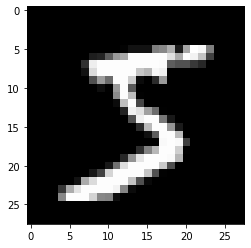

In [3]:
plt.imshow(trainset[0][0][0], cmap='gray')

## 1. What does CNN do?

In [4]:
convolution_kernel = torch.Tensor([ [1, 0, -1,], [1,0,-1], [1,0,-1] ])

In [5]:
convolution_kernel

tensor([[ 1.,  0., -1.],
        [ 1.,  0., -1.],
        [ 1.,  0., -1.]])

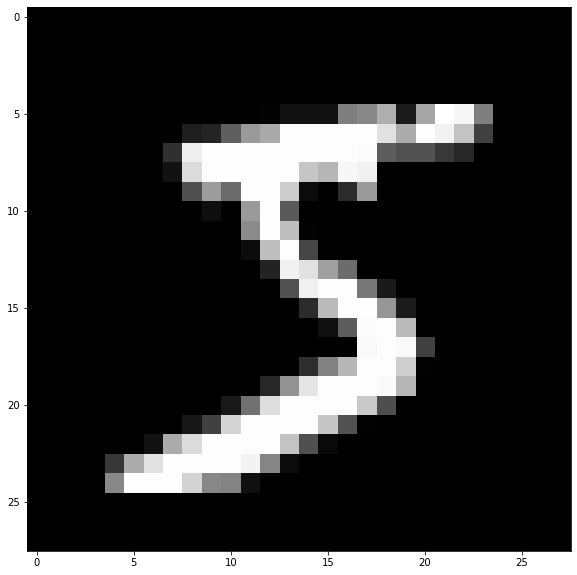

In [7]:
letter_image = trainset[0][0][0]
plt.figure(figsize=(10,10))
plt.imshow(letter_image, cmap='gray')

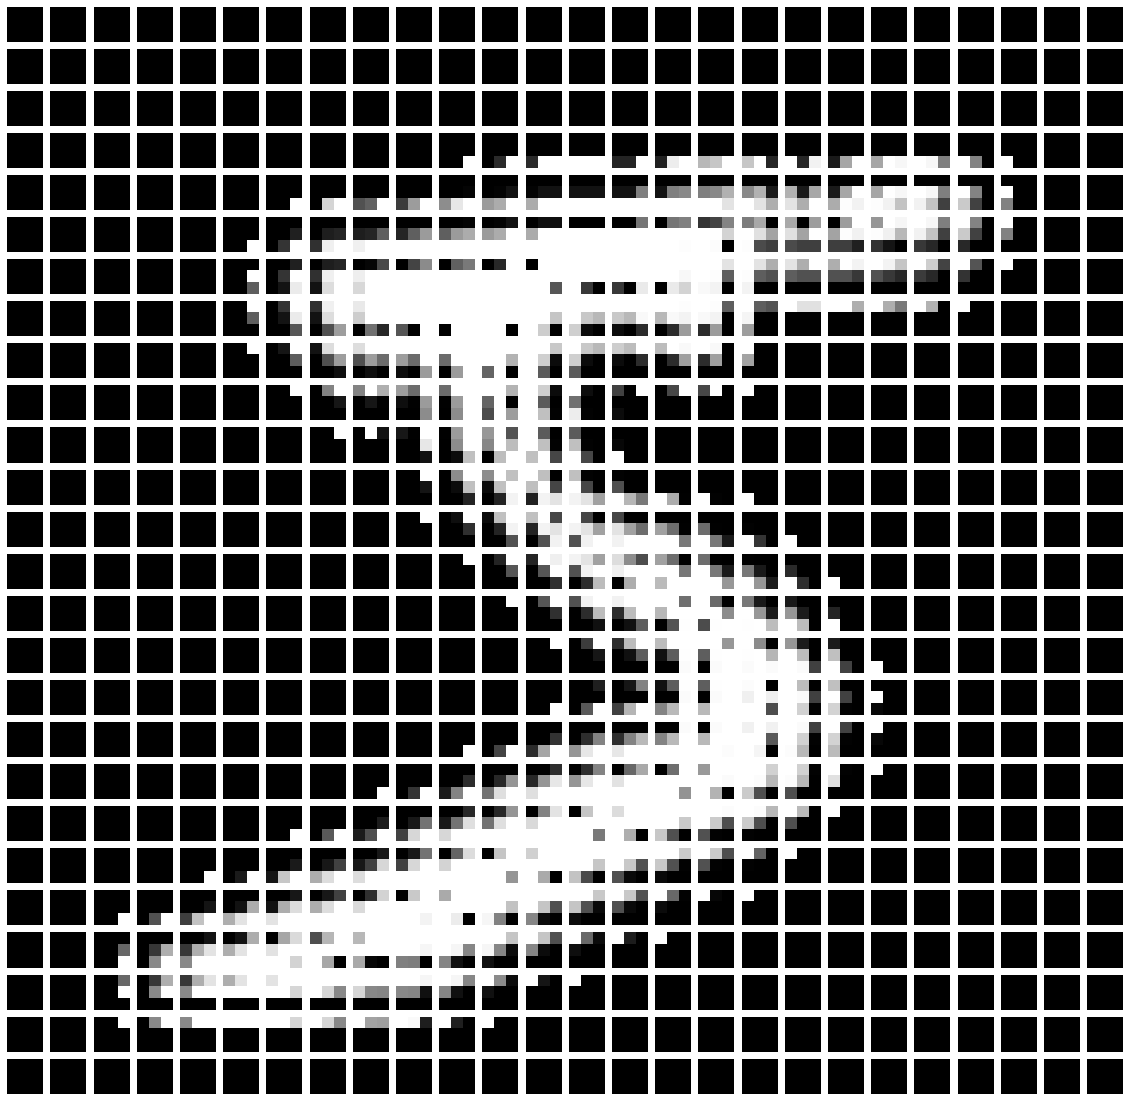

In [8]:
plt.figure(figsize=(20,20))
for i in range(1,27):
  for j in range(1,27):
    sliced_input = letter_image[i-1:i+2, j-1:j+2]
    plt.subplot(26,26,j+(i-1)*26)
    plt.imshow(sliced_input, cmap='gray')
    plt.axis('off')

In [9]:
sliced_input = letter_image[14:17, 17:20]
sliced_input

tensor([[0.4667, 0.0980, 0.0000],
        [0.9922, 0.5882, 0.1059],
        [0.9882, 0.9922, 0.7333]])

In [10]:
convolution_kernel

tensor([[ 1.,  0., -1.],
        [ 1.,  0., -1.],
        [ 1.,  0., -1.]])

In [12]:
(sliced_input * convolution_kernel).sum()

tensor(1.6078)

In [13]:
sliced_input.shape, convolution_kernel.shape

(torch.Size([3, 3]), torch.Size([3, 3]))

In [15]:
flattened_input = sliced_input.reshape(9)
flattened_kernel = convolution_kernel.reshape(9)

flattened_input, flattened_kernel

(tensor([0.4667, 0.0980, 0.0000, 0.9922, 0.5882, 0.1059, 0.9882, 0.9922, 0.7333]),
 tensor([ 1.,  0., -1.,  1.,  0., -1.,  1.,  0., -1.]))

In [16]:
torch.matmul(flattened_input, flattened_kernel)

tensor(1.6078)

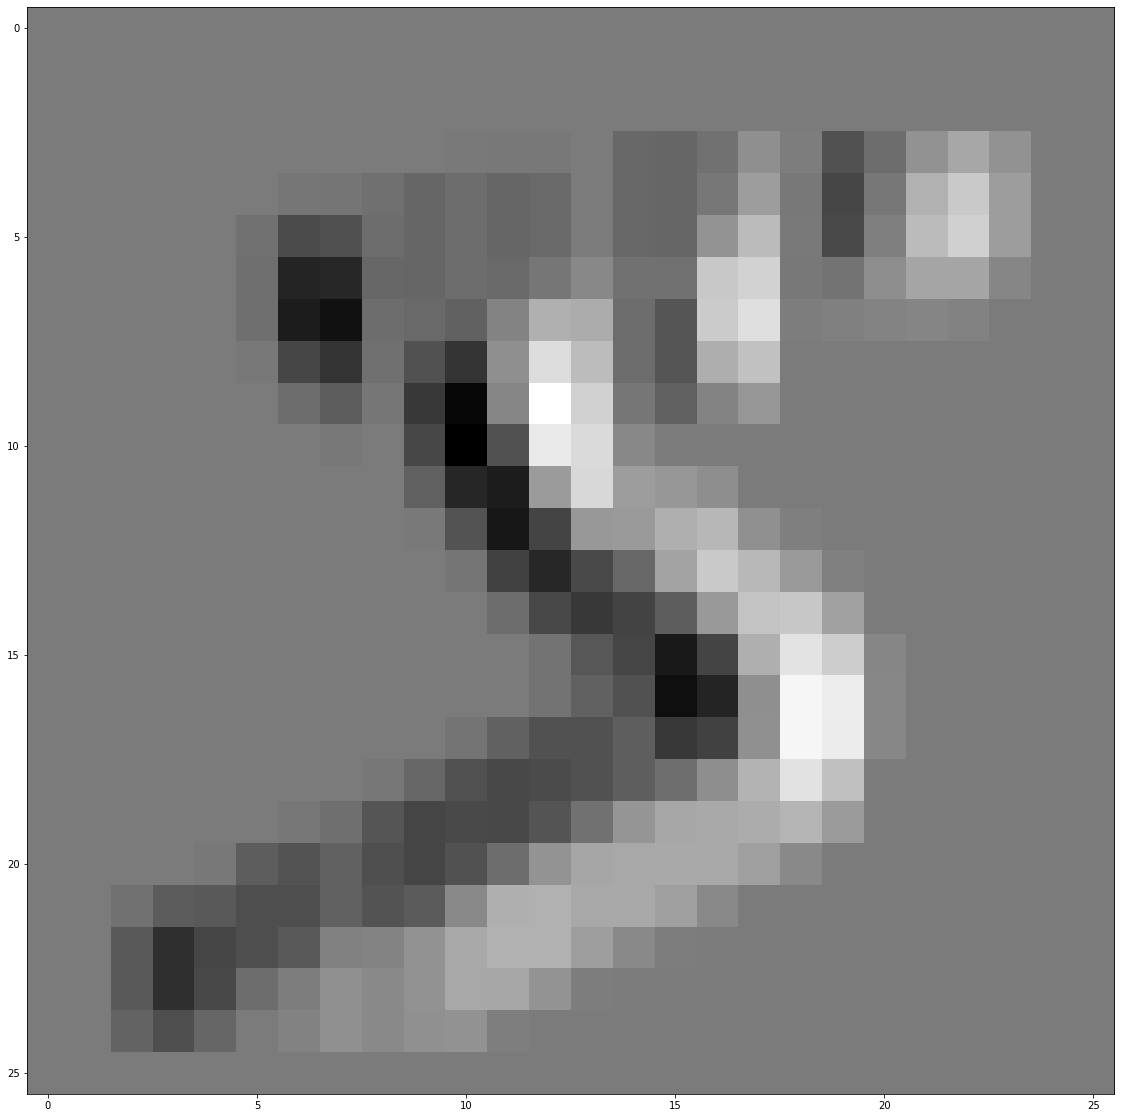

In [17]:
plt.figure(figsize=(20,20))
kernel_total_out = torch.zeros([26,26])
for i in range(1,27):
  for j in range(1,27):
    sliced_input = letter_image[i-1:i+2, j-1:j+2]
    kernel_output = (convolution_kernel *sliced_input).sum()
    kernel_total_out[i-1,j-1] = kernel_output
plt.imshow(kernel_total_out, cmap='gray')

In [29]:
conv_layer = torch.nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3)
conv_layer.weight, conv_layer.weight.shape

img = letter_image.unsqueeze(0)
# img.shape

out = conv_layer(img)
out

tensor([[[ 0.0522,  0.0522,  0.0522,  ...,  0.0522,  0.0522,  0.0522],
         [ 0.0522,  0.0522,  0.0522,  ...,  0.0522,  0.0522,  0.0522],
         [ 0.0522,  0.0522,  0.0522,  ...,  0.0522,  0.0522,  0.0522],
         ...,
         [ 0.0522,  0.0522,  0.1964,  ...,  0.0522,  0.0522,  0.0522],
         [ 0.0522,  0.0522,  0.0232,  ...,  0.0522,  0.0522,  0.0522],
         [ 0.0522,  0.0522,  0.0522,  ...,  0.0522,  0.0522,  0.0522]],

        [[-0.2104, -0.2104, -0.2104,  ..., -0.2104, -0.2104, -0.2104],
         [-0.2104, -0.2104, -0.2104,  ..., -0.2104, -0.2104, -0.2104],
         [-0.2104, -0.2104, -0.2104,  ..., -0.2104, -0.2104, -0.2104],
         ...,
         [-0.2104, -0.2104, -0.4071,  ..., -0.2104, -0.2104, -0.2104],
         [-0.2104, -0.2104, -0.3441,  ..., -0.2104, -0.2104, -0.2104],
         [-0.2104, -0.2104, -0.2104,  ..., -0.2104, -0.2104, -0.2104]]],
       grad_fn=<SqueezeBackward1>)

## 2. How Fully Connected Layer worked

In [3]:
train_loader = DataLoader(trainset, batch_size=256, shuffle=True, pin_memory=True)
valid_loader = DataLoader(testset, batch_size=512, shuffle=False)

In [4]:
class FCNClassifier(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.layers = nn.Sequential(
          nn.Linear(784, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size,hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size,10)
    )
  def forward(self, x):
    return self.layers(x.view(-1,784))
  


In [5]:
def train_loop(model, optimizer, train_loader, valid_loader, loss_func, acc_func, num_epochs, device):
  model = model.to(device)
  model.train()
  
  loss_record = {'train_loss':[], 'valid_acc':[]}
  for epoch in tqdm.tqdm(range(num_epochs)):
    for batch in train_loader:
      img, label = batch
      pred = model(img.to(device))
      log_softmax_pred = torch.log(torch.softmax(pred, dim=-1)+1e-6)
      loss = loss_func(log_softmax_pred, label.to(device))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_record['train_loss'].append(loss.item())
    with torch.no_grad():
      model.eval()
      val_acc = 0
      for batch in valid_loader:
        img, label = batch
        pred = model(img.to(device))
        acc = acc_func(pred, label.to(device))
        val_acc += acc * len(img)
      loss_record['valid_acc'].append(val_acc/len(valid_loader.dataset))
      model.train()
  return loss_record 

def get_accuracy(pred, target):
  pred_class = torch.argmax(pred, dim=-1)
  return (pred_class==target).float().mean().item()

model = FCNClassifier(hidden_size=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = torch.nn.NLLLoss()


train_result = train_loop(model, optimizer, train_loader, valid_loader, loss_func,get_accuracy, 10, 'cuda')

100%|██████████| 10/10 [01:00<00:00,  6.03s/it]


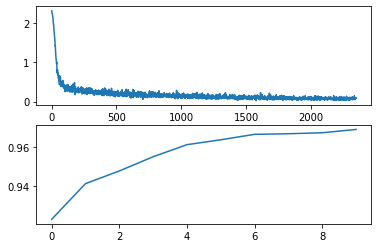

In [6]:
plt.subplot(2,1,1)
plt.plot(train_result['train_loss'])
plt.subplot(2,1,2)
plt.plot(train_result['valid_acc'])

In [7]:
batch = next(iter(train_loader))
img, label = batch
pred = model(img.to('cuda'))

### 2.1 Visualizing FCN weights

In [9]:
model

FCNClassifier(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

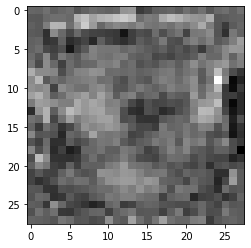

In [16]:
model = model.to('cpu')
selected_neuron_id = 6
selected_weight = model.layers[0].weight[selected_neuron_id].detach()

plt.imshow(selected_weight.view(28,28), cmap='gray')


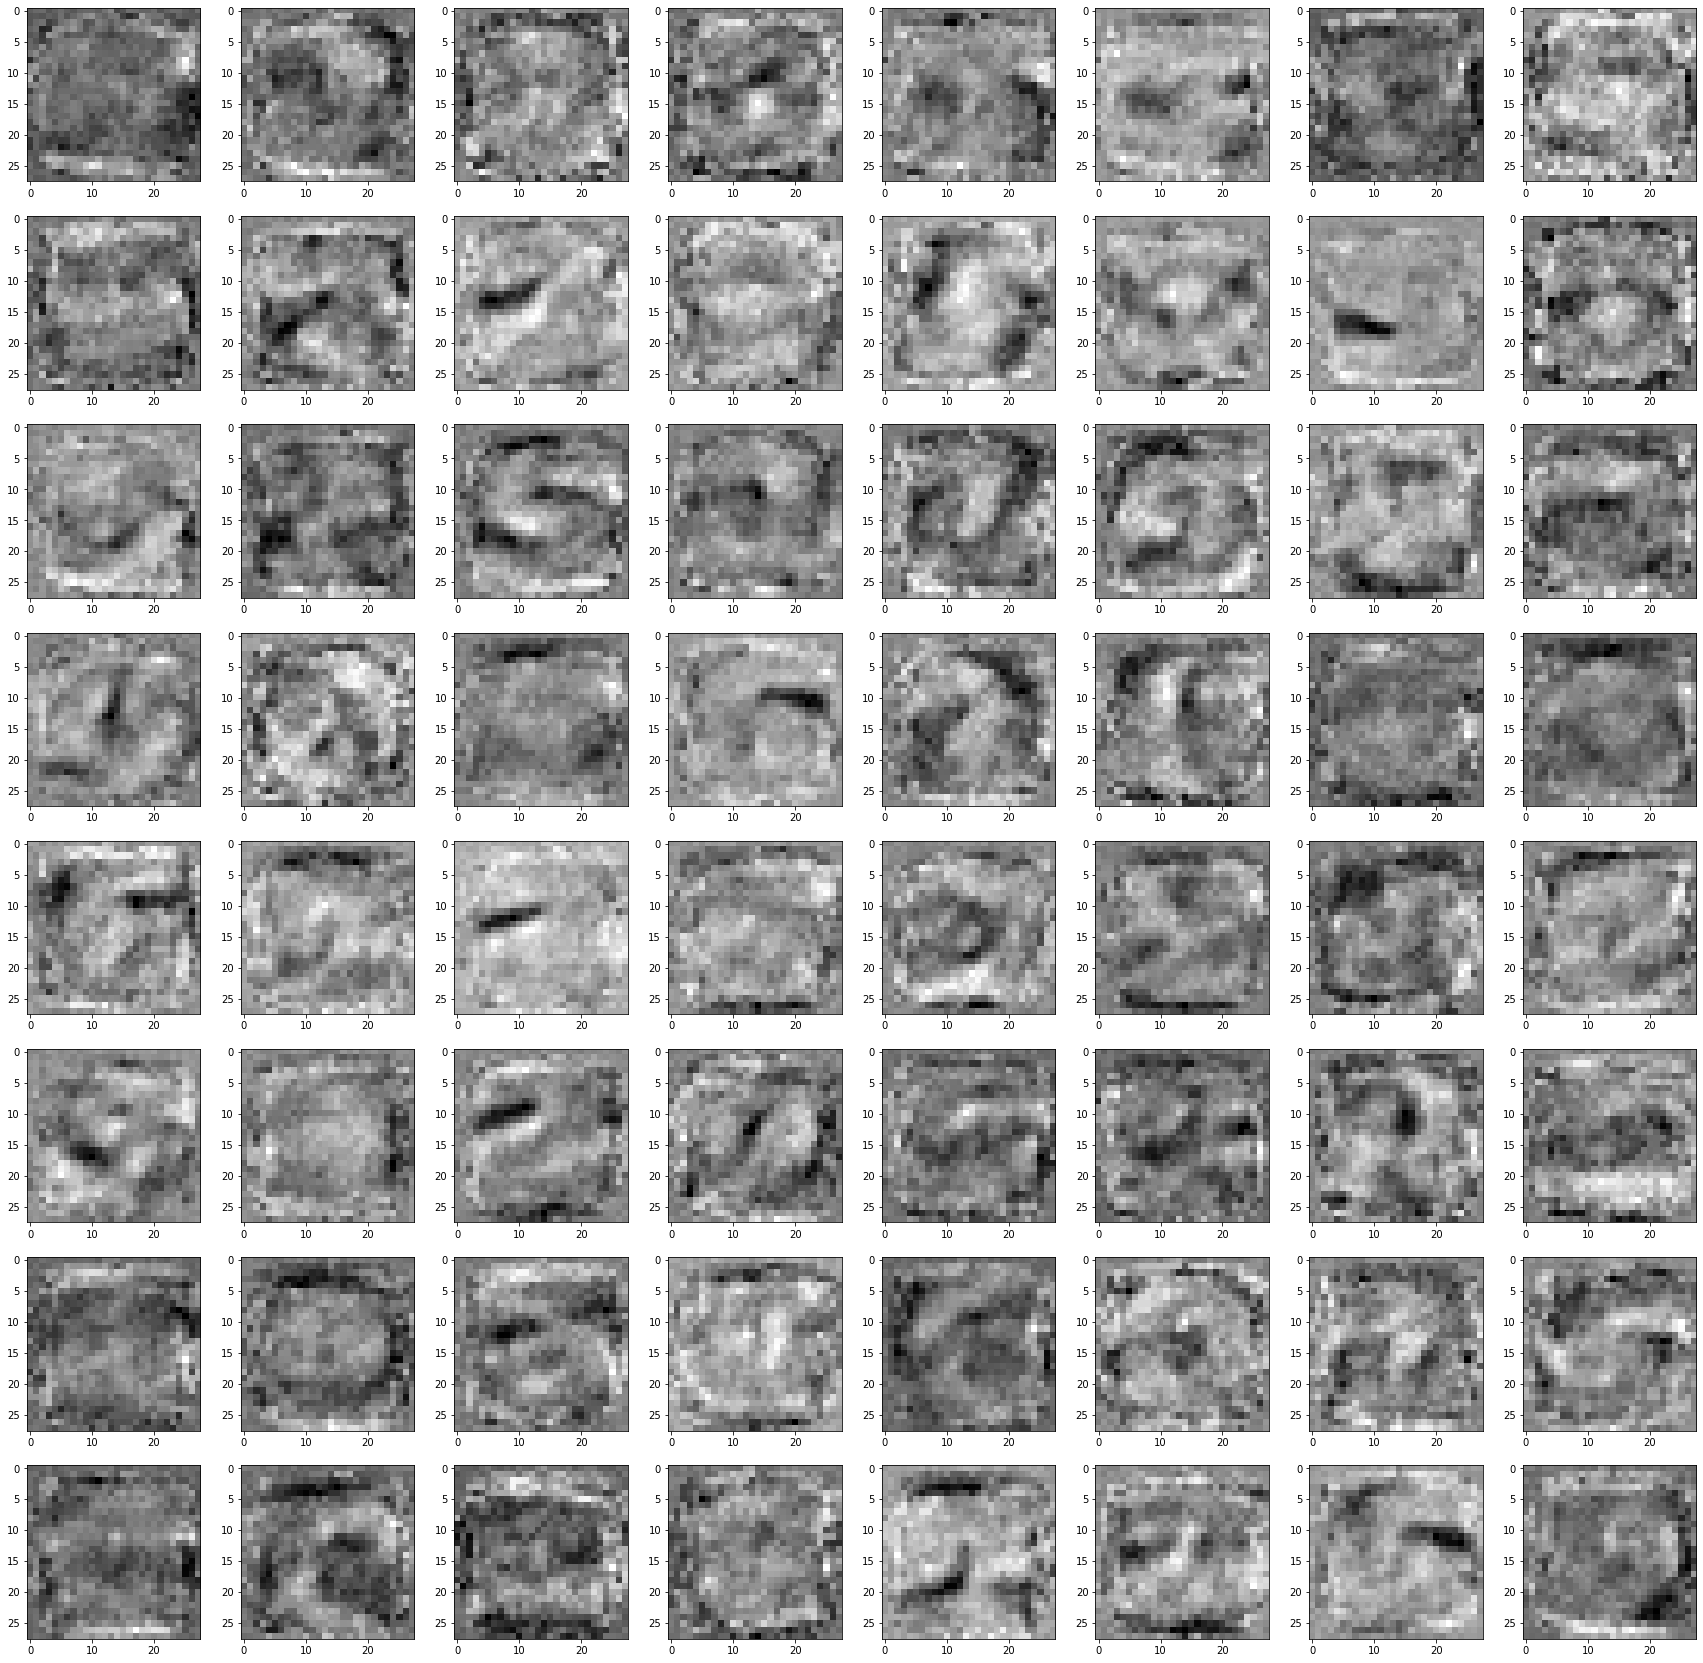

In [17]:
plt.figure(figsize=(30,30))
for i in range(8):
  for j in range(8):
    cur_id = i*8+j
    selected_weight = model.layers[0].weight[cur_id].detach().view(28,28)
    plt.subplot(8,8,cur_id+1)
    plt.imshow(selected_weight, cmap='gray')

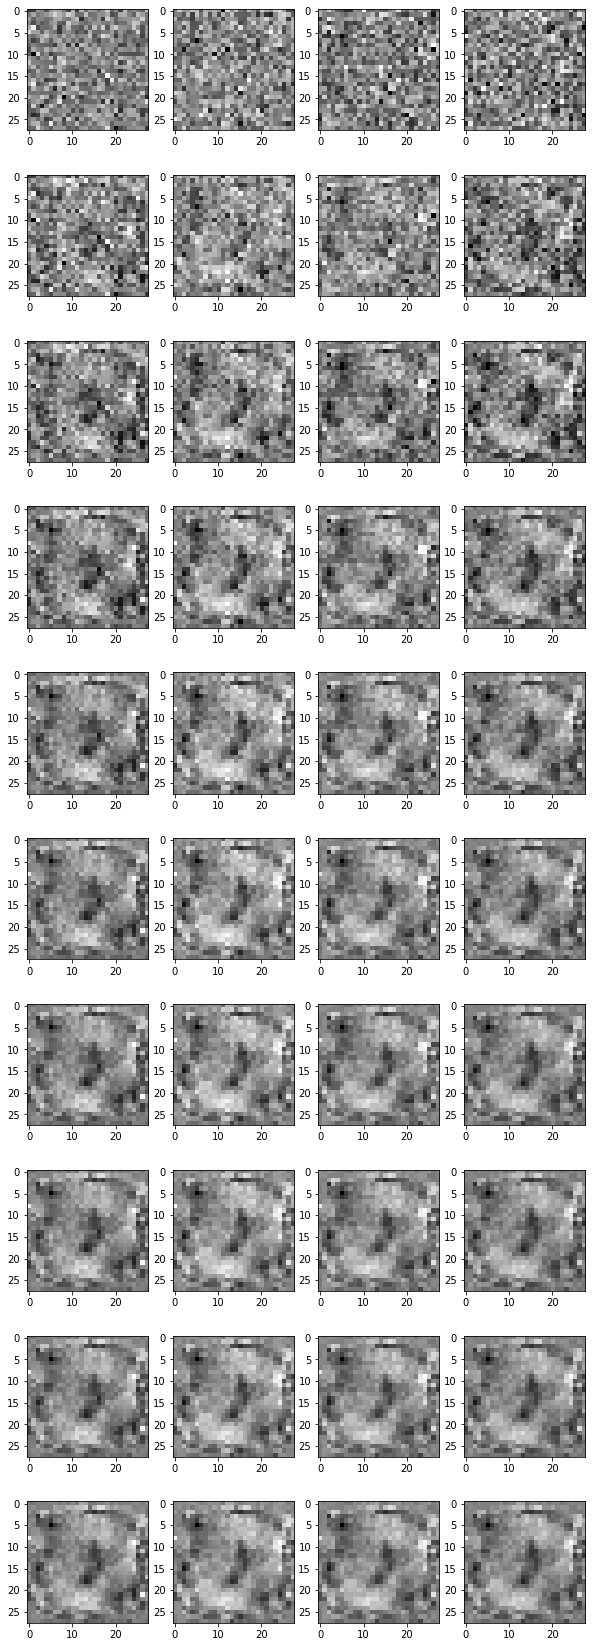

In [21]:
def freeze_model(model):
  for param in model.parameters():
    param.requires_grad = False

def unfreeze_model(model):
  for param in model.parameters():
    param.requires_grad = True

freeze_model(model)
dummy_input = torch.randn(784*4)
dummy_input = dummy_input.view(4,784)
dummy_input.requires_grad=True

selected_mid_neuron_id = 0
plt.figure(figsize=(10,30))
dummy_optimizer = torch.optim.SGD([dummy_input], lr=1)
for i in range(200):
  mid_output = model.layers(dummy_input)
  loss = -mid_output[:,selected_mid_neuron_id].mean()
  loss.backward()
#   dummy_input.data -= dummy_input.grad * 0.03
  dummy_optimizer.step()
  dummy_optimizer.zero_grad()
  if i % 20 == 0:
    for j in range(4):
      plt.subplot(10, 4, (i//20)*4+1+j)
      plt.imshow(torch.Tensor(dummy_input[j]).detach().view(28,28), cmap='gray')

## 3. Make CNN with torch

In [ ]:
cnn_layer = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3,3))

In [ ]:
dummy_input = torch.randn(25).view(5,5)

In [ ]:
dummy_input

tensor([[-1.7735, -0.2046, -0.1535, -0.7833, -0.0177],
        [ 0.3489,  0.2893, -0.2754, -1.4016,  0.3827],
        [-0.4865,  0.3875, -0.6479,  0.0128, -1.8287],
        [ 0.9274, -0.8546,  0.6695,  0.1136,  1.0328],
        [ 0.2794, -0.6051, -1.6486,  0.4161, -0.8496]])

In [23]:
class CNNClassifier(nn.Module):
  def __init__(self, hidden_size, kernel_size):
    super().__init__()
    self.layers = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=hidden_size, kernel_size=kernel_size),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size),
          nn.ReLU(),
          nn.MaxPool2d(2),
    )
    self.final_layer = nn.Linear(hidden_size, 10)
  def forward(self, x):
    out = self.layers(x)
    pooled_out = nn.functional.max_pool2d(out, out.shape[2])
    return self.final_layer(pooled_out[:,:,0,0])

cnn_model = CNNClassifier(64, 5)



In [24]:
cnn_model = CNNClassifier(64, 5)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)
loss_func = torch.nn.NLLLoss()

cnn_train_result = train_loop(cnn_model, cnn_optimizer, train_loader, valid_loader, loss_func,get_accuracy, 10, 'cuda')

100%|██████████| 10/10 [01:21<00:00,  8.15s/it]


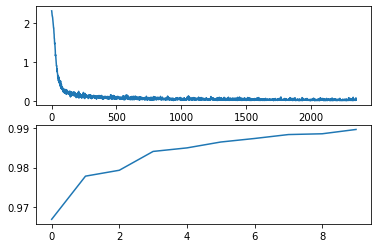

In [25]:
plt.subplot(2,1,1)
plt.plot(cnn_train_result['train_loss'])
plt.subplot(2,1,2)
plt.plot(cnn_train_result['valid_acc'])

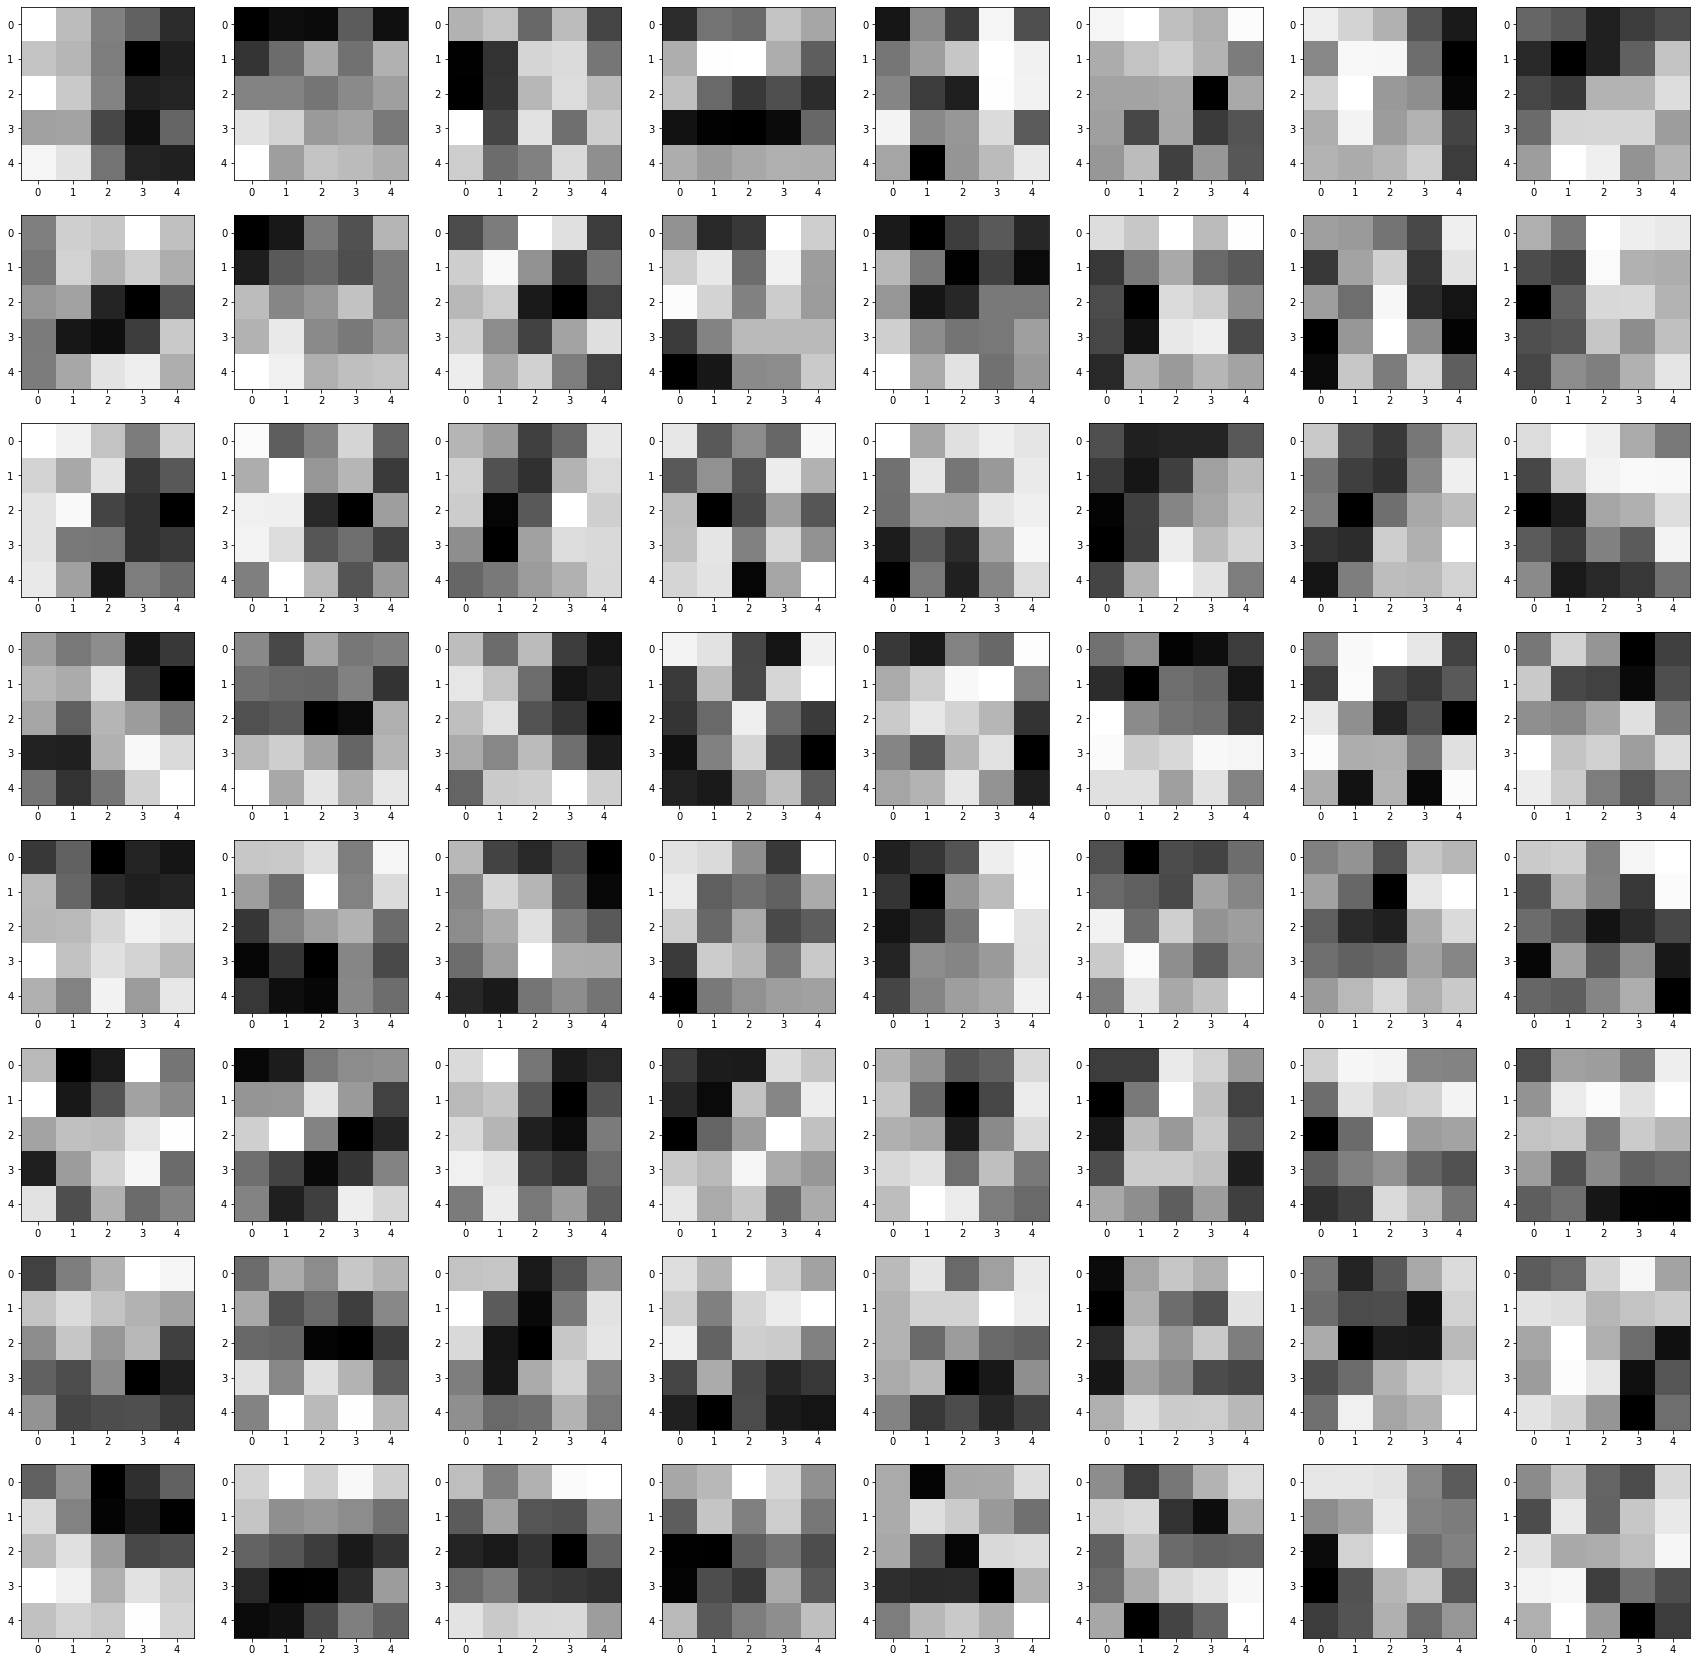

In [26]:
cnn_model = cnn_model.to('cpu')
plt.figure(figsize=(30,30))
for i in range(8):
  for j in range(8):
    cur_id = i*8+j
    selected_weight = cnn_model.layers[0].weight[cur_id].detach().view(5,5)
    plt.subplot(8,8,cur_id+1)
    plt.imshow(selected_weight, cmap='gray')

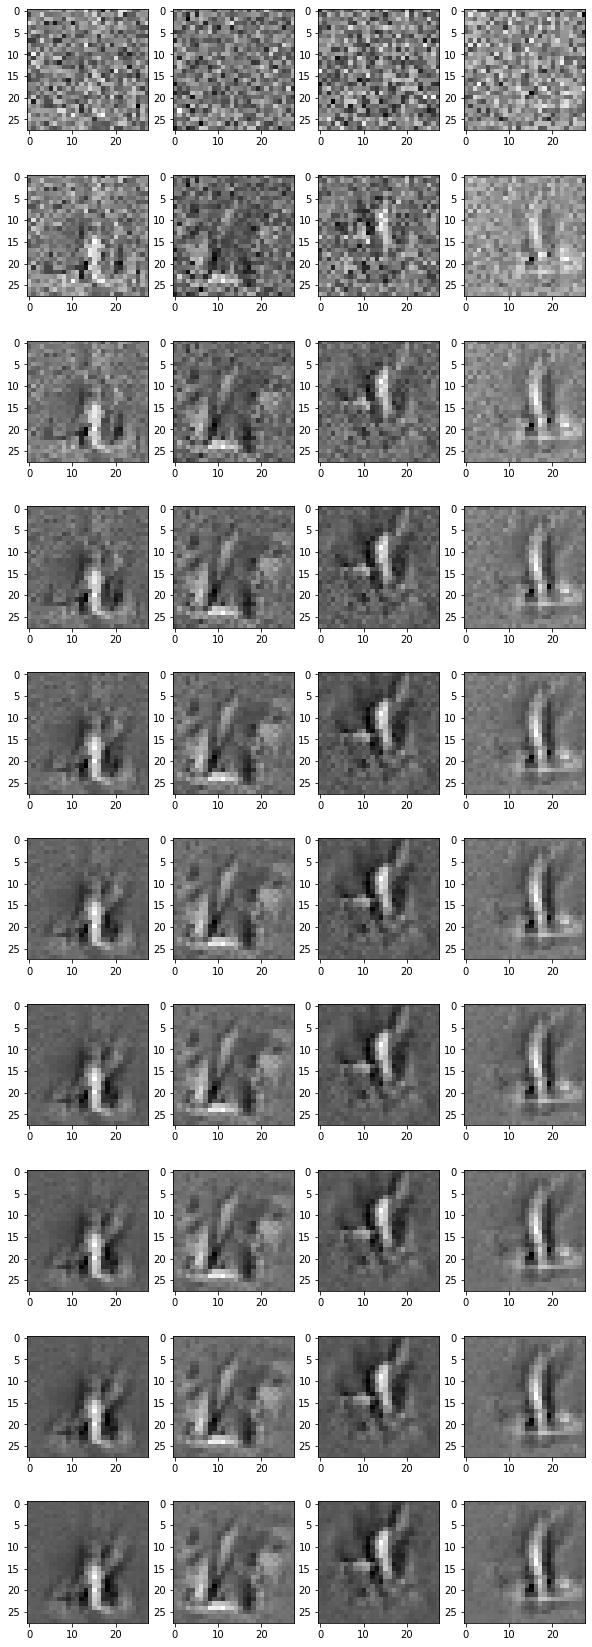

In [29]:

freeze_model(cnn_model)
dummy_input = torch.randn(784*4)
dummy_input = dummy_input.view(4,1,28,28)
dummy_input.requires_grad=True

selected_mid_neuron_id = 1
plt.figure(figsize=(10,30))
dummy_optimizer = torch.optim.SGD([dummy_input], lr=0.5)
for i in range(500):
#   mid_output = cnn_model.layers(dummy_input)
  mid_output = cnn_model(dummy_input)
  loss = -mid_output[:,selected_mid_neuron_id].mean()
  loss.backward()
#   dummy_input.data -= dummy_input.grad * 0.8
#   dummy_input.grad = None
  dummy_optimizer.step()
  dummy_optimizer.zero_grad()
  if i % 50 == 0:
    for j in range(4):
      plt.subplot(10, 4, (i//50)*4+1+j)
      plt.imshow(torch.Tensor(dummy_input[j]).detach().view(28,28), cmap='gray')

### Transpose_invariant

In [30]:
test_batch = next(iter(valid_loader))

In [31]:
test_img = test_batch[0]
shifted_example = torch.zeros_like(test_img)
shifted_example[:,:,1:,:] = test_img[:,:,:-1,:]

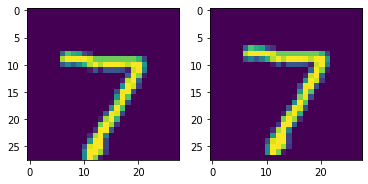

In [32]:
plt.subplot(1,2,1)
plt.imshow(shifted_example[0][0])
plt.subplot(1,2,2)
plt.imshow(test_img[0][0])

In [33]:
device = 'cuda'
model = model.to(device)
cnn_model = cnn_model.to(device)
for batch in valid_loader:
  img, label = batch
  img = img.to(device)
  shifted_example = torch.zeros_like(img)
  shifted_example[:,:,2:] = img[:,:,:-2,:]
  
  fcn_pred = model(shifted_example)
  cnn_pred = cnn_model(shifted_example)
  
  fcn_acc = get_accuracy(fcn_pred, label.to(device))
  cnn_acc = get_accuracy(cnn_pred, label.to(device))
  
  org_pred = model(img)
  org_cnn_pred = cnn_model(img)
  
  org_fcn_acc = get_accuracy(org_pred, label.to(device))
  org_cnn_acc = get_accuracy(org_cnn_pred, label.to(device))
  
  print(fcn_acc, cnn_acc, org_fcn_acc, org_cnn_acc)

0.7890625 0.9609375 0.9765625 0.98828125
0.796875 0.96484375 0.95703125 0.98046875
0.7265625 0.962890625 0.947265625 0.982421875
0.78125 0.95703125 0.947265625 0.984375
0.7890625 0.947265625 0.955078125 0.98046875
0.765625 0.974609375 0.97265625 0.9921875
0.76953125 0.966796875 0.958984375 0.990234375
0.763671875 0.953125 0.94140625 0.982421875
0.720703125 0.953125 0.951171875 0.98828125
0.759765625 0.970703125 0.978515625 0.9921875
0.833984375 0.984375 0.986328125 1.0
0.783203125 0.97265625 0.958984375 0.9921875
0.8125 0.958984375 0.9609375 0.978515625
0.798828125 0.99609375 0.99609375 0.99609375
0.79296875 0.98046875 0.994140625 0.998046875
0.796875 0.978515625 0.990234375 1.0
0.775390625 0.986328125 0.984375 0.994140625
0.806640625 0.990234375 0.984375 0.99609375
0.755859375 0.98046875 0.98046875 0.990234375
0.5625 0.9595588445663452 0.9558823704719543 0.9852941036224365
